# Classificação de dados

In [39]:
import numpy as np
import pandas as pd

In [40]:
train_path = '../data/raw/train.csv'
df = pd.read_csv(train_path)

In [41]:
df.drop(axis = 1, columns=['id'], inplace=True)

In [42]:
df.isnull().sum()

brand               0
model               0
model_year          0
milage              0
fuel_type        5083
engine              0
transmission        0
ext_col             0
int_col             0
accident         2452
clean_title     21419
price               0
dtype: int64

In [43]:
df.clean_title.unique()

array(['Yes', nan], dtype=object)

In [44]:
df.head(10)

,brand,model,model_year,milage,fuel_type,engine,transmission,ext_col,int_col,accident,clean_title,price
0,MINI,Cooper S Base,2007,213000,Gasoline,172.0HP 1.6L 4 Cylinder Engine Gasoline Fuel,A/T,Yellow,Gray,None reported,Yes,4200
1,Lincoln,LS V8,2002,143250,Gasoline,252.0HP 3.9L 8 Cylinder Engine Gasoline Fuel,A/T,Silver,Beige,At least 1 accident or damage reported,Yes,4999
2,Chevrolet,Silverado 2500 LT,2002,136731,E85 Flex Fuel,320.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,Blue,Gray,None reported,Yes,13900
3,Genesis,G90 5.0 Ultimate,2017,19500,Gasoline,420.0HP 5.0L 8 Cylinder Engine Gasoline Fuel,Transmission w/Dual Shift Mode,Black,Black,None reported,Yes,45000
4,Mercedes-Benz,Metris Base,2021,7388,Gasoline,208.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,7-Speed A/T,Black,Beige,None reported,Yes,97500
5,Audi,A6 2.0T Sport,2018,40950,Gasoline,252.0HP 2.0L 4 Cylinder Engine Gasoline Fuel,A/T,White,–,None reported,Yes,29950
6,Audi,A8 L 3.0T,2016,62200,Gasoline,333.0HP 3.0L V6 Cylinder Engine Gasoline Fuel,8-Speed A/T,Black,Black,None reported,Yes,28500
7,Chevrolet,Silverado 1500 1LZ,2016,102604,E85 Flex Fuel,355.0HP 5.3L 8 Cylinder Engine Flex Fuel Capab...,A/T,White,Gray,None reported,Yes,12500
8,Ford,F-150 XLT,2020,38352,Gasoline,2.7L V6 24V PDI DOHC Twin Turbo,10-Speed Automatic,Snowflake White Pearl Metallic,Black,None reported,Yes,62890
9,BMW,M4 Base,2015,74850,Gasoline,425.0HP 3.0L Straight 6 Cylinder Engine Gasoli...,Transmission w/Dual Shift Mode,Black,Blue,None reported,Yes,4000


In [45]:
def remove_outliers_iqr(df, column):   
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1   
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR    
    df_out = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df_out

df_train_no_outliers = remove_outliers_iqr(df, 'milage')
df_train_no_outliers = remove_outliers_iqr(df_train_no_outliers, 'price')
df_train_no_outliers.reset_index(drop=True, inplace=True)
df = df_train_no_outliers
df.shape

(175900, 12)

## Classificação

In [76]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn.pipeline import Pipeline

# Técnicas de pré-processamento
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import FunctionTransformer

# Técnicas de avaliação/validação
from sklearn.metrics import mean_squared_error


In [47]:
seed = 42

In [ ]:
# Identificando as variáveis categóricas e numéricas no dataset
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
numerical_features = df.drop(columns=['price']).select_dtypes(exclude=['object']).columns.tolist()

def multiplicar_colunas(df_):
    df_['engine_transmission'] = df_['engine'] * df_['transmission']
    df_.drop(columns = ['engine','transmission'])
    return df_

# Criando os transformadores

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combinando transformadores com ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), numerical_features),
    ('cat', categorical_transformer, categorical_features),
    ('multiplicacao', FunctionTransformer(multiplicar_colunas, validate=False))
])

# Criando pipelines para KNN e Decision Tree
knn_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('knn', KNeighborsRegressor())
])

tree_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('tree', DecisionTreeRegressor(random_state=42))
])


In [ ]:
categorical_features

['brand',
 'model',
 'fuel_type',
 'engine',
 'transmission',
 'ext_col',
 'int_col',
 'accident',
 'clean_title']

In [83]:
X = df.drop(columns=['price'])
y = df['price']

# Dividindo os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [84]:
knn_ = knn_pipeline.fit(X_train, y_train)
tree_ = tree_pipeline.fit(X_train, y_train)

ValueError: not enough values to unpack (expected 3, got 2)

In [68]:
knn_predicao = knn_.predict(X_test)
tree_predicao = tree_.predict(X_test)

In [69]:
print('Erro medio quadratico Knn: ', mean_squared_error(knn_predicao, y_test))
print('Erro medio quadratico Tree: ', mean_squared_error(tree_predicao, y_test))

Erro medio quadratico Knn:  209027403.1413417
Erro medio quadratico Tree:  317808241.1913082


In [70]:
print(tree_.predict(X_test[29:30]), y_test[29:30])

[33499.] 78143    59999
Name: price, dtype: int64


In [71]:
df_new = pd.DataFrame({'real': y_test, 'predito_knn': knn_predicao, 'predito_tree': tree_predicao})

In [72]:
df_new.sample(10)

,real,predito_knn,predito_tree
146419,19500,16140.0,13999.0
142531,5900,12279.0,5500.0
105971,7000,11430.0,5899.0
86817,20800,24403.8,11995.0
175790,13500,23719.0,17000.0
15156,18750,21439.8,28000.0
44383,5200,8880.0,21990.0
34605,20850,47699.8,29995.0
83153,7500,8300.0,9500.0
9755,26500,32179.0,22995.0


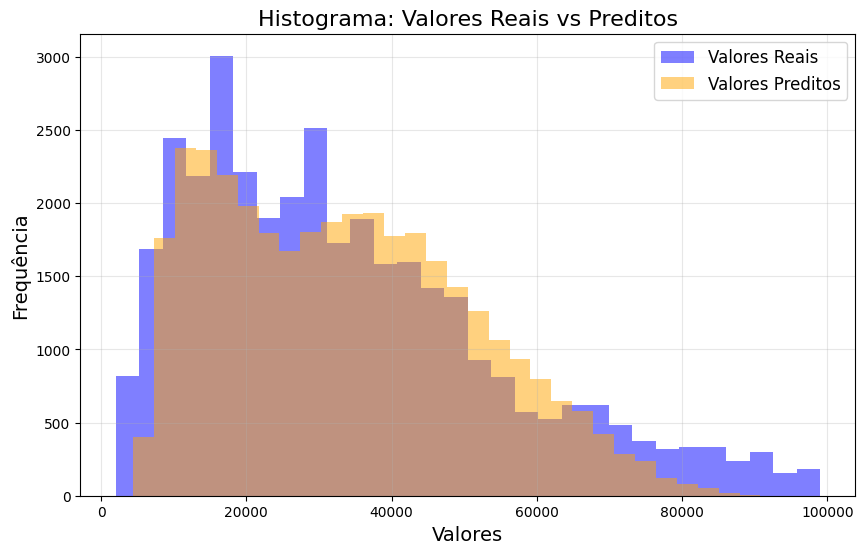

In [73]:
import matplotlib.pyplot as plt

# Criando o histograma
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Valores Reais', color='blue')
plt.hist(knn_predicao, bins=30, alpha=0.5, label='Valores Preditos', color='orange')

# Configurando o gráfico
plt.title('Histograma: Valores Reais vs Preditos', fontsize=16)
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Exibindo o gráfico
plt.show()


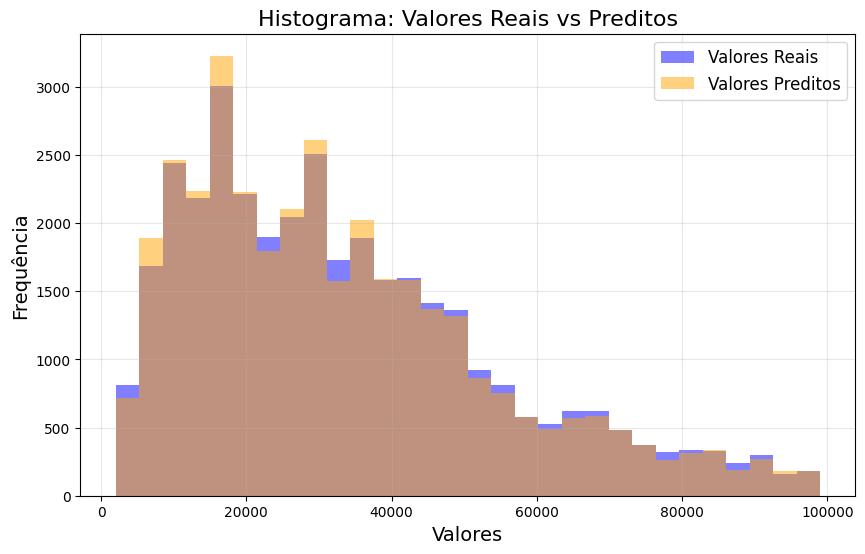

In [74]:
plt.figure(figsize=(10, 6))
plt.hist(y_test, bins=30, alpha=0.5, label='Valores Reais', color='blue')
plt.hist(tree_predicao, bins=30, alpha=0.5, label='Valores Preditos', color='orange')

# Configurando o gráfico
plt.title('Histograma: Valores Reais vs Preditos', fontsize=16)
plt.xlabel('Valores', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.legend(fontsize=12)
plt.grid(alpha=0.3)

# Exibindo o gráfico
plt.show()
